# **Data Pre-Processing:**


---

Since WSIs are megapixel in resolution, our goal is to pre-process these images into image 512 x 512 image patches and later downsample to 224 x 224 to match CNN input dimensions. Since Camelyon16 is very well anotated, we can randomly sample for normal patches, and use binary mask annotations for tumor patches.

While Grand Challenge has split up WSI files into training and testing sets, we will only be using the training dataset since the test set has hidden labels.

Note: Grand Challenge no longer allows the download of the Camelyon16 dataset, so we found partial datasets on Kaggle and downloaded to our local machines before uploading to drive.

In [ ]:
# Install OpenSlide
!apt-get install -y openslide-tools
!pip install openslide-python

import os
import numpy as np
from PIL import Image
import openslide
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# sanity check for file pathways
!ls "/VisTumor/Training_Data/raw_data"

normal6  tumor3


Available levels: 10
Selected level dimensions: (3056, 6912)
Selected scaaled level dimensions: (12224, 27648)


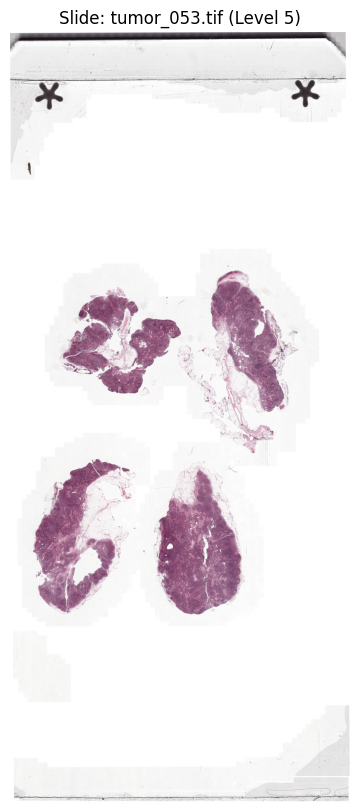

In [ ]:
# SANITY CHECK: VISUALIZATION

# Path to your slide (.tif file)
slide_path = '/VisTumor/Training_Data/raw_data/tumor3/tumor_053.tif'  # change as needed

# Open the WSI
slide = openslide.OpenSlide(slide_path)

# Pick a low-res level for visualization
level = 5  # or 4 if available; lower = higher resolution
level_change = 3
print("Available levels:", slide.level_count)
print("Selected level dimensions:", slide.level_dimensions[level])
print("Selected scaaled level dimensions:", slide.level_dimensions[level_change])

# Read entire slide at this level
img = slide.read_region((0, 0), level, slide.level_dimensions[level])
img = img.convert('RGB')  # Remove alpha channel

# Convert to numpy for matplotlib
img_np = np.array(img)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.title(f'Slide: {slide_path.split("/")[-1]} (Level {level})')
plt.axis('off')
plt.show()

# Close the slide when done
slide.close()

##Image Segmentation (i.e. get rid of white/blank regions) ##

Level 3 Slides are 10,000 x 10,000 pixels. We want to extract patches of 512 x 512 pixels (capture more spatial information) with overlap in stride to collect as much training data as possible on a limited dataset. We will threshold to make sure that patches contain actual cells and not background information.

In [ ]:
# === PATCH EXTRACTION FOR NORMAL WSI ===

import os
import random
import numpy as np
from PIL import Image
import openslide
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import cv2

# === CONFIGURATION ===

# file paths and hyperparameters
WSI_DIR = "/VisTumor/Training_Data/raw_data/normal6"
OUTPUT_DIR = "/VisTumor/Training_Data/training_patches/Normal"
PATCH_SIZE = 512
LEVEL = 3
STRIDE = 256

# === THRESHOLDING ===
def is_tissue(patch, gray_upper_thresh=0.6, dark_lower_thresh=0.1):
    np_patch = np.array(patch.convert('L'))
    total_pixels = np_patch.size
    gray_pixels = np.sum(np_patch > 200) / total_pixels
    dark_pixels = np.sum(np_patch < 30) / total_pixels
    return gray_pixels < gray_upper_thresh and dark_pixels < dark_lower_thresh

# === EXTRACT PATCHES ===
def extract_and_save_patches(slide_path, output_dir):
  slide = openslide.OpenSlide(slide_path)
  w, h = slide.level_dimensions[LEVEL]
  slide_name = os.path.splitext(os.path.basename(slide_path))[0]
  downsample = slide.level_downsamples[LEVEL]

  patches = []

  total_x = (w - PATCH_SIZE) // STRIDE + 1
  total_y = (h - PATCH_SIZE) // STRIDE + 1
  total_iters = total_x * total_y

  progress_bar = tqdm(total=total_iters, desc="Extracting patches")

  for x in range(0, w - PATCH_SIZE + 1, STRIDE):
    for y in range(0, h - PATCH_SIZE + 1, STRIDE):
      loc_x = int(x * downsample)
      loc_y = int(y * downsample)
      patch = slide.read_region((loc_x, loc_y), LEVEL, (PATCH_SIZE, PATCH_SIZE)).convert("RGB")
      if is_tissue(patch):
        filename = f"{slide_name}_{x}_{y}.png"
        patch.save(os.path.join(output_dir, filename))
      progress_bar.update(1)

  progress_bar.close()
  slide.close()

Since tumor slides mostly consist of normal/healthy tissue with select regions of cancer, when creating patches, we compare them to annotation masks to make sure each patch contains at least 5% cancerous tissue.

In [ ]:
# === PATCH EXTRACTION FOR TUMOR WSI ===

import os
import random
import numpy as np
from PIL import Image
import openslide
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import cv2

# === CONFIGURATION ===

# changes file paths when choosing between normal6 and tumor3
TUMOR_WSI_DIR = "/VisTumor/Training_Data/raw_data/tumor3"
TUMOR_MASK_DIR = "/VisTumor/Training_Data/evaluation_masks"
TUMOR_OUTPUT_DIR = "t/VisTumor/Training_Data/training_patches/Tumor"
PATCH_SIZE = 512
LEVEL = 3
STRIDE = 128

# === EXTRACT PATCHES ===

def extract_tumor_patches(slide_path, mask_path, output_dir):

  # open slide and mask
  slide = openslide.OpenSlide(slide_path)
  mask_img = Image.open(mask_path).convert("L") # grayscale
  slide_name = os.path.splitext(os.path.basename(slide_path))[0]

  # get slide and mask dimensions
  w, h = slide.level_dimensions[LEVEL]
  downsample_lvl5 = slide.level_downsamples[5]
  downsample_lvl3 = slide.level_downsamples[LEVEL]

  # rescale mask to match slide dimensions
  scale_factor = downsample_lvl5 / downsample_lvl3
  new_w = int(mask_img.width * scale_factor)
  new_h = int(mask_img.height * scale_factor)
  resized_mask = mask_img.resize((new_w, new_h), resample=Image.NEAREST)

  # converts mask to binary np array
  mask_np = np.array(resized_mask)
  tumor_mask = (mask_np > 0).astype(np.uint8)

  # progress tracking
  total_x = (w - PATCH_SIZE) // STRIDE + 1
  total_y = (h - PATCH_SIZE) // STRIDE + 1
  total_iters = total_x * total_y

  progress_bar = tqdm(total=total_iters, desc="Extracting patches")

  for x in range(0, w - PATCH_SIZE + 1, STRIDE):
    for y in range(0, h - PATCH_SIZE + 1, STRIDE):

      # check if tumor is in the present patch (at least 5%, just a common heuristic)
      mask_patch = tumor_mask[y : y + PATCH_SIZE, x : x + PATCH_SIZE]
      if mask_patch.sum() > (PATCH_SIZE ** 2 * 0.05):
        loc_x = int(x * downsample_lvl3)
        loc_y = int(y * downsample_lvl3)
        patch = slide.read_region((loc_x, loc_y), LEVEL, (PATCH_SIZE, PATCH_SIZE)).convert("RGB")

        filename = f"{slide_name}_{x}_{y}.png"
        patch.save(os.path.join(output_dir, filename))
      progress_bar.update(1)

  progress_bar.close()
  slide.close()

In [ ]:
# === NORMAL LOOP ===
for file in os.listdir(WSI_DIR):
  if not file.endswith(".tif"):
    continue
  slide_path = os.path.join(WSI_DIR, file)
  print(f"Processing {file}...")
  patches = extract_and_save_patches(slide_path, OUTPUT_DIR)

Processing tumor_053.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_054.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_055.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_056.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_057.tif...


Extracting patches:   0%|          | 0/4876 [00:00<?, ?it/s]

Processing tumor_058.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_059.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_060.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_061.tif...


Extracting patches:   0%|          | 0/4876 [00:00<?, ?it/s]

Processing tumor_062.tif...


Extracting patches:   0%|          | 0/4876 [00:00<?, ?it/s]

Processing tumor_063.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_064.tif...


Extracting patches:   0%|          | 0/4876 [00:00<?, ?it/s]

Processing tumor_065.tif...


Extracting patches:   0%|          | 0/4876 [00:00<?, ?it/s]

Processing tumor_066.tif...


Extracting patches:   0%|          | 0/4830 [00:00<?, ?it/s]

Processing tumor_067.tif...


Extracting patches:   0%|          | 0/4922 [00:00<?, ?it/s]

Processing tumor_068.tif...


Extracting patches:   0%|          | 0/4830 [00:00<?, ?it/s]

Processing tumor_069.tif...


Extracting patches:   0%|          | 0/4830 [00:00<?, ?it/s]

Processing tumor_070.tif...


Extracting patches:   0%|          | 0/4876 [00:00<?, ?it/s]

Processing tumor_071.tif...


Extracting patches:   0%|          | 0/3649 [00:00<?, ?it/s]

Processing tumor_072.tif...


Extracting patches:   0%|          | 0/2982 [00:00<?, ?it/s]

Processing tumor_101.tif...


Extracting patches:   0%|          | 0/2278 [00:00<?, ?it/s]

Processing tumor_102.tif...


Extracting patches:   0%|          | 0/5145 [00:00<?, ?it/s]

Processing tumor_103.tif...


Extracting patches:   0%|          | 0/3564 [00:00<?, ?it/s]

Processing tumor_104.tif...


Extracting patches:   0%|          | 0/3024 [00:00<?, ?it/s]

Processing tumor_105.tif...


Extracting patches:   0%|          | 0/2244 [00:00<?, ?it/s]

Processing tumor_106.tif...


Extracting patches:   0%|          | 0/3621 [00:00<?, ?it/s]

Processing tumor_107.tif...


Extracting patches:   0%|          | 0/1833 [00:00<?, ?it/s]

Processing tumor_108.tif...


Extracting patches:   0%|          | 0/3111 [00:00<?, ?it/s]

Processing tumor_109.tif...


Extracting patches:   0%|          | 0/2646 [00:00<?, ?it/s]

Processing tumor_110.tif...


Extracting patches:   0%|          | 0/1530 [00:00<?, ?it/s]

Processing tumor_111.tif...


Extracting patches:   0%|          | 0/4876 [00:00<?, ?it/s]

In [ ]:
# Note: we did this portion in batches to make sure Colab doesn't crash from memory constraints

BATCH_SIZE = 6
BATCH_INDEX = 5

# === TUMOR LOOP ===

all_slides = sorted([f for f in os.listdir(TUMOR_WSI_DIR) if f.endswith(".tif")])
total_batches = math.ceil(len(all_slides) / BATCH_SIZE)

# gets the slides in the current batch
start = BATCH_INDEX * BATCH_SIZE
end = start + BATCH_SIZE
batch_slides = all_slides[start:end]

print(f"Processing batch {BATCH_INDEX + 1} of {total_batches} ({len(batch_slides)} slides)")

for file in batch_slides:

  # finds file path and corresponding mask path
  slide_path = os.path.join(TUMOR_WSI_DIR, file)
  mask_file = os.path.splitext(file)[0] + "_evaluation_mask.png"
  mask_path = os.path.join(TUMOR_MASK_DIR, mask_file)

  # makes sure mask path exists
  if not os.path.exists(mask_path):
    print(f"Mask missing for {file}, skipping.")
    continue

  print(f"Processing {file}...")
  extract_tumor_patches(slide_path, mask_path, TUMOR_OUTPUT_DIR)

Processing batch 6 of 6 (1 slides)
Mask missing for tumor_111.tif, skipping.
